## Check the data
values seem ok, but some columns have max repeated a lot → likely outliers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import parse_data

df = parse_data.df

print(df.describe())
print(df.isnull().sum())
print(df.shape)

       median_house_value     longitude      latitude  housing_median_age  \
count        20640.000000  20640.000000  20640.000000        20640.000000   
mean        206855.816909   -119.569704     35.631861           28.639486   
std         115395.615874      2.003532      2.135952           12.585558   
min          14999.000000   -124.350000     32.540000            1.000000   
25%         119600.000000   -121.800000     33.930000           18.000000   
50%         179700.000000   -118.490000     34.260000           29.000000   
75%         264725.000000   -118.010000     37.710000           37.000000   
max         500001.000000   -114.310000     41.950000           52.000000   

              rooms      bedrooms    population    households  median_income  
count  20640.000000  20433.000000  20640.000000  20640.000000   20640.000000  
mean    2635.763081    537.870553   1425.476744    499.539680       3.870671  
std     2181.615252    421.385070   1132.462122    382.329753       1

In [2]:
# count how many times each column hits max → checking for possible outliers
columns = df.columns.tolist()
check_max = {}

for column in columns:
    count_of_max = (df[column] == df[column].max()).sum()
    check_max[column] = count_of_max

for i in check_max:
    print(f"{i}: {check_max[i]}")

median_house_value: 965
longitude: 1
latitude: 2
housing_median_age: 1273
rooms: 1
bedrooms: 1
population: 1
households: 1
median_income: 49


## About the outliers

several columns have repeated max → treat as outliers
housing_median_age, median_income, median_house_value

In [3]:
# remove outliers (just drop rows equal to max)
outlier_columns = ["housing_median_age", "median_income", "median_house_value"]
for i in outlier_columns:
    df = df[df[i] < df[i].max()]

In [4]:
# bedrooms null vs not-null → check price difference
price_null = df[df["bedrooms"].isnull()]["median_house_value"]
price_not_null = df[df["bedrooms"].notnull()]["median_house_value"]

u_statistic, p_value = stats.mannwhitneyu(
    price_null, price_not_null, alternative="two-sided"
)

print(f"Mann-Whitney U Test P-value: {p_value:.5f}")
print(f"median of null: {price_null.median():.2f}")
print(f"median of non-null: {price_not_null.median():.2f}")

Mann-Whitney U Test P-value: 0.59573
median of null: 170600.00
median of non-null: 171200.00


## the distribution between null and not-null groups
p>0.05 → no strong difference between null and not-null groups
so dropping rows with null bedrooms likely ok.

In [5]:
df = df.dropna()

check log-normality using Q-Q plots

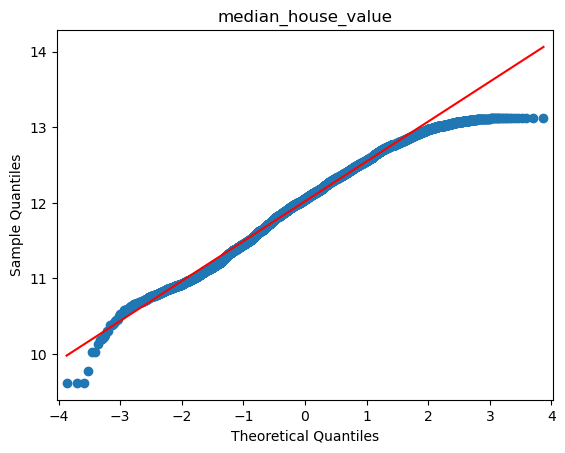

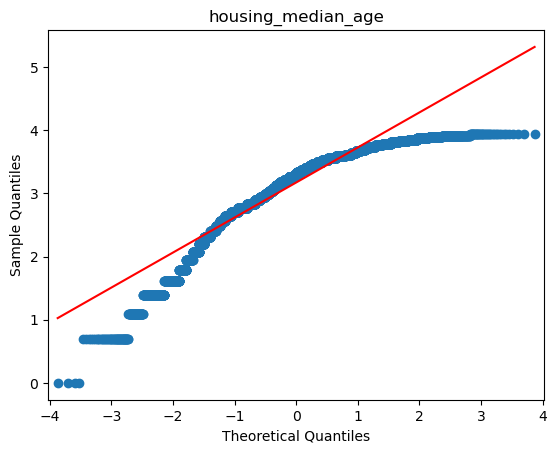

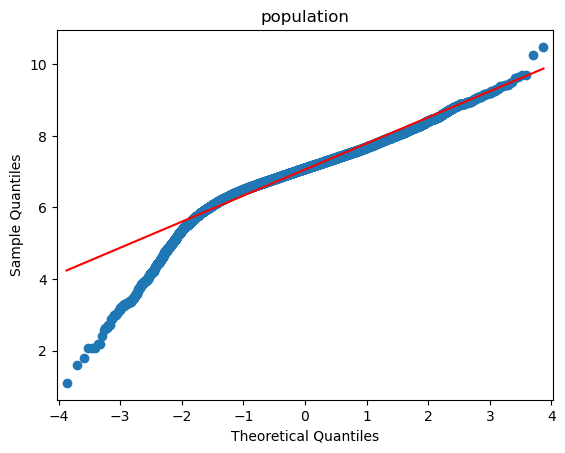

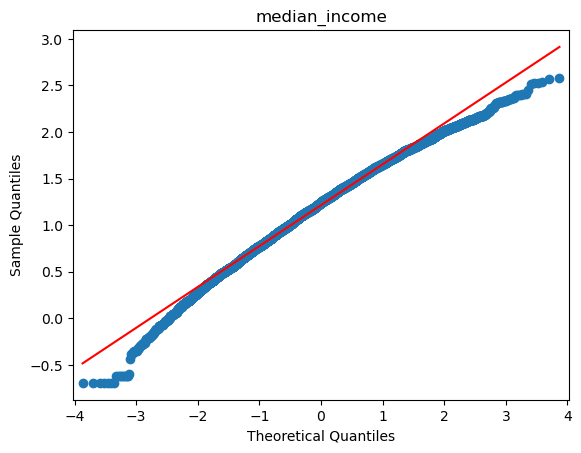

In [6]:
def qq_plot(column):
    data = np.log(df[column])
    sm.qqplot(data, line="s")
    plt.title(column)
    plt.show()


qq_list = ["median_house_value", "housing_median_age", "population", "median_income"]
for i in qq_list:
    qq_plot(i)

From Q-Q plot: median_house_value and median_income look log-normal
(almost linear between theoretical quantiles −2 to +2)

In [7]:
# some engineered features
df["avg_rooms_per_hh"] = df["rooms"] / df["households"]
df["avg_people_per_hh"] = df["population"] / df["households"]
df["median_income_log"] = np.log(df["median_income"])
df["median_house_value_log"] = np.log(df["median_house_value"])

In [8]:
# compare correlations by income groups (top 25% vs others)
q3_income = df["median_income"].quantile(0.75)

df_high_income = df[df["median_income"] >= q3_income]
df_other_income = df[df["median_income"] < q3_income]

print(
    f"high-income N={len(df_high_income)}, low&middle-income N={len(df_other_income)}"
)

high-income N=4595, low&middle-income N=13782


In [9]:
def calculate_and_compare_corr(df1, df2, label1, label2):
    results = {}
    for feature in ["median_income_log", "avg_rooms_per_hh", "avg_people_per_hh"]:
        corr1, p1 = stats.pearsonr(df1["median_house_value_log"], df1[feature])
        corr2, p2 = stats.pearsonr(df2["median_house_value_log"], df2[feature])

        results[feature] = {
            f"{label1} Corr": corr1,
            f"{label1} P": p1,
            f"{label2} Corr": corr2,
            f"{label2} P": p2,
        }
    return pd.DataFrame(results).T


corr_results = calculate_and_compare_corr(
    df_high_income, df_other_income, "High Income", "Other Income"
)

print("\ncorrelation of income")
print(corr_results)


correlation of income
                   High Income Corr  High Income P  Other Income Corr  \
median_income_log          0.504252  5.648484e-295           0.490635   
avg_rooms_per_hh           0.025359   8.564696e-02          -0.056164   
avg_people_per_hh         -0.060545   4.011932e-05          -0.026840   

                   Other Income P  
median_income_log    0.000000e+00  
avg_rooms_per_hh     4.166108e-11  
avg_people_per_hh    1.626034e-03  


## correlation results:

+ median_income_log: strongest correlation with house value in both groups
  (P extremely small: not random)
  + Higher median income areas tend to have higher house values, suggesting that
    neighborhood wealth strongly drives property prices. It also implies that
    local economic conditions may matter more than individual household size or rooms.

+ avg_rooms_per_hh: almost no relation in high income, but negative in other group
  (may reflect resource dilution / housing quality)
  + In lower/middle-income areas, more rooms per household might indicate
    larger, older, or lower-quality housing where income per person is diluted.
    High-income households may have uniformly large, high-quality homes, so the
    number of rooms doesn't differentiate house values much.

+ avg_people_per_hh: weak negative in both groups
  (larger households slightly lower house value)
  + Larger households may put pressure on financial resources, leading to lower
    property values per capita. Alternatively, densely populated households
    could correlate with smaller or less desirable homes.

p-values small in most → correlations unlikely random and statistically reliable